# Model Airfield Runway Optimization
For many pilots, take-offs and landings represent the most difficult stages of flight. This is especially true for remote control model aircraft pilots. Crosswinds pose an acute danger during those delicate phases of flight. Crosswinds are wind components perpendicular to the path of travel. For take-offs and landings, crosswinds are necessarily those perpendicular to the runway. Runways are orientated to optimize favorable headwind conditions and reduce crosswinds.

My local model airfield, Lear Field, in Guymon, Oklahoma is considering adding two additional runways. This project will be investigating the local wind patterns and determining optimum runway placement algorithmically. To accomplish this, the one-minute ASOS data archive from the National Climatic Data Center, provided through the Iowa Environmental Mesonet, will be used. The nearest ASOS station is Guymon Municipal Airport, roughly three and a half miles from Lear Field. Data included will be from the year range 2012-2021.

*Note: ASOS reports are stored in METAR format, which uses true headings, not magnetic.*

## Data Preparation

We will begin by loading the station data into a pandas dataframe. If the csv file is not located in the notebook directory, then we will download and save the file.

In [1]:
import pandas
from io import StringIO
from urllib.request import urlopen

YEAR_START = 2012
YEAR_END = 2021
INTERVAL = '1min'

def format_uri(station_id):
    return ("https://mesonet.agron.iastate.edu/request/asos/1min_dl.php?station%5B%5D={0}&tz=UTC&year1={1}&month1=1&day1=1&hour1=0&minute1=0&year2={2}&month2=12&day2=31&hour2=23&minute2=59&vars%5B%5D=sknt&vars%5B%5D=drct&sample={3}&what=view&delim=comma&gis=yes"
            .format(station_id, YEAR_START, YEAR_END, INTERVAL)
    )

def get_data(station_id):
    try:
        file_name = (
            '{0}_{1}-{2}_{3}.csv'
            .format(station_id, YEAR_START, YEAR_END, INTERVAL)
        )
        return pandas.read_csv(file_name)
    except (FileNotFoundError, pandas.errors.ParserError):
        uri = format_uri(station_id)
        data = urlopen(uri, timeout=300).read().decode("utf-8")
        with open(file_name, 'w') as file:
            file.write(data)
        return pandas.read_csv(StringIO(data), sep=',')
    
wind = get_data('GUY')

Let's take a look at the resulting dataframe.

In [2]:
wind.head()

,station,station_name,lat,lon,valid(UTC),sknt,drct,Unnamed: 7
0,GUY,GUYMON,36.68167,-101.50528,2012-01-01 09:16,12.0,321.0,NaN
1,GUY,GUYMON,36.68167,-101.50528,2012-01-01 09:17,11.0,319.0,NaN
2,GUY,GUYMON,36.68167,-101.50528,2012-01-01 09:18,11.0,319.0,NaN
3,GUY,GUYMON,36.68167,-101.50528,2012-01-01 09:19,12.0,319.0,NaN
4,GUY,GUYMON,36.68167,-101.50528,2012-01-01 09:20,12.0,319.0,NaN


In [3]:
wind.tail()

,station,station_name,lat,lon,valid(UTC),sknt,drct,Unnamed: 7
4674751,GUY,GUYMON,36.68167,-101.50528,2021-12-31 15:46,20.0,241.0,NaN
4674752,GUY,GUYMON,36.68167,-101.50528,2021-12-31 15:47,20.0,241.0,NaN
4674753,GUY,GUYMON,36.68167,-101.50528,2021-12-31 15:48,20.0,241.0,NaN
4674754,GUY,GUYMON,36.68167,-101.50528,2021-12-31 15:49,20.0,240.0,NaN
4674755,GUY,GUYMON,36.68167,-101.50528,2021-12-31 15:50,NaN,NaN,NaN


In [4]:
wind.describe()

,lat,lon,sknt,drct,Unnamed: 7
count,4.674756e+06,4.674756e+06,4.629181e+06,4.629181e+06,0.0
mean,3.668167e+01,-1.015053e+02,9.639085e+00,1.835576e+02,NaN
std,3.339551e-13,7.673862e-13,5.599063e+00,9.663449e+01,NaN
min,3.668167e+01,-1.015053e+02,0.000000e+00,1.000000e+00,NaN
25%,3.668167e+01,-1.015053e+02,6.000000e+00,1.280000e+02,NaN
50%,3.668167e+01,-1.015053e+02,9.000000e+00,1.870000e+02,NaN
75%,3.668167e+01,-1.015053e+02,1.300000e+01,2.400000e+02,NaN
max,3.668167e+01,-1.015053e+02,1.110000e+02,3.600000e+02,NaN


In [5]:
wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4674756 entries, 0 to 4674755
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   station       object 
 1   station_name  object 
 2   lat           float64
 3   lon           float64
 4   valid(UTC)    object 
 5   sknt          float64
 6   drct          float64
 7   Unnamed: 7    float64
dtypes: float64(5), object(3)
memory usage: 285.3+ MB


In [6]:
wind.isnull().sum()

station               0
station_name          0
lat                   0
lon                   0
valid(UTC)            0
sknt              45575
drct              45575
Unnamed: 7      4674756
dtype: int64

Looking at the dataframe, `station` and `station_name` are unnecessary. `Unnamed: 7` is completely unknown. Let's drop those columns.

In [7]:
wind = wind.drop(columns=['Unnamed: 7', 'station', 'station_name'])
wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4674756 entries, 0 to 4674755
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   lat         float64
 1   lon         float64
 2   valid(UTC)  object 
 3   sknt        float64
 4   drct        float64
dtypes: float64(4), object(1)
memory usage: 178.3+ MB


All measurements appear to be from the same reported latitude and longitude. To double-check:

In [8]:
print(wind.lat.unique(), wind.lon.unique())

[36.68167] [-101.50528]


It looks like all the rows have the same latitude and longitude. Let's move latitude and longitude outside the dataframe to save resources.

In [9]:
LAT = wind.lat[0]
LON = wind.lon[0]
wind = wind.drop(columns=['lat', 'lon'])
print("LAT: %.4f, LON: %.4f" % (LAT, LON))
wind.info()

LAT: 36.6817, LON: -101.5053
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4674756 entries, 0 to 4674755
Data columns (total 3 columns):
 #   Column      Dtype  
---  ------      -----  
 0   valid(UTC)  object 
 1   sknt        float64
 2   drct        float64
dtypes: float64(2), object(1)
memory usage: 107.0+ MB


The `sknt` column is wind speed in knots. Let's make the units  more familiar by converting it to miles per hour. We should also rename the column.

In [10]:
# 1 knot is defined as 1852 meters / h
#            cm/knt   cm/in in/ft ft/mi == mph
KNT_TO_MPH = 185200 / 2.54 / 12 / 5280

wind['sknt'] = wind['sknt'] * KNT_TO_MPH
wind = wind.rename(columns={'sknt': 'mph'})

wind.head()

,valid(UTC),mph,drct
0,2012-01-01 09:16,13.809353,321.0
1,2012-01-01 09:17,12.658574,319.0
2,2012-01-01 09:18,12.658574,319.0
3,2012-01-01 09:19,13.809353,319.0
4,2012-01-01 09:20,13.809353,319.0


Ensure the `valid(UTC)` column is a UTC datetime...

In [11]:
wind['valid(UTC)'] = pandas.to_datetime(wind['valid(UTC)'], utc=True)

Drop duplicates...

In [12]:
wind = wind.drop_duplicates(subset=['valid(UTC)'], keep='first')

And set it as the index.

In [13]:
wind = wind.set_index('valid(UTC)')
wind.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4674756 entries, 2012-01-01 09:16:00+00:00 to 2021-12-31 15:50:00+00:00
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   mph     float64
 1   drct    float64
dtypes: float64(2)
memory usage: 107.0 MB


Plotting the sample time deltas may provide some insight to station downtime.

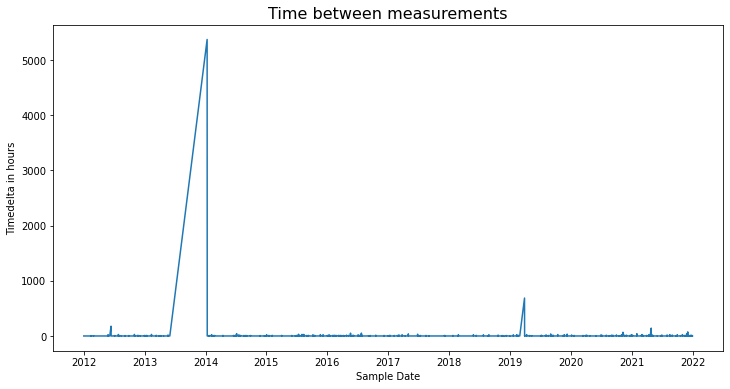

In [14]:
import matplotlib.pyplot as plot

plot.figure(figsize=(12, 6))
plot.title('Time between measurements', fontsize=16)
plot.xlabel('Sample Date')
plot.ylabel('Timedelta in hours')
plot.plot(wind.index.to_series().diff().astype('timedelta64[h]'));

It appears that the station was not operational for the majority of 2013. There is another noticeable spike in 2019. More on this later.

Let's resample the data to an hourly time series. However, before we can do this, the headings will need to be converted to unit vectors in order for sensible averaging of the wind direction. First, we define a function to convert from degrees to vector components. It is important to note that the function should be vectorized to speed up processing.

In [15]:
import numpy as np

# Headings are degrees from north, so cos and sin are reversed from expected
def heading_to_vector(headings):
    x = np.sin(headings * np.pi / 180.0)
    y = np.cos(headings * np.pi / 180.0)
    return np.vstack((x, y)).T

We will also multiply the resulting components by their corresponding magnitudes.

In [16]:
wind['mph_x'], wind['mph_y'] = (heading_to_vector(wind.drct)
                            * np.array([wind.mph]).T).T

Now resample to hourly and ensure index covers entire datetime range.

In [17]:
wind = wind.resample('H').mean()
index_dates = (
    pandas
    .date_range(
        start=('1/1/%s' % YEAR_START), 
        end=('1/1/%s' % (YEAR_END+1)), 
        freq='1H', 
        tz='UTC', 
        inclusive='left'
    )
)
wind = wind.reindex(index=index_dates)

The headings can now be reestablished by a vector to heading function defined as:

In [18]:
def vector_to_heading(unit_x, unit_y):
    headings = np.arctan2(unit_x, unit_y) * 180 / np.pi
    return np.where(headings >= 0, headings, headings + 360)

We can now calculate the new average wind headings.

In [19]:
wind.drct = vector_to_heading(wind.mph_x, wind.mph_y)

## NaN Values

The plotted time deltas above seem to indicate outages at several points over the 10-year period. Let's check how many rows have NaN values.

In [20]:
wind.isnull().any(axis=1).sum()

9901

In [21]:
wind.isnull().all(axis=1).sum()

9901

In [22]:
print("NaN: %.2f%%" % (
    100 
    * wind.isnull().all(axis=1).sum() 
    / wind.isnull().all(axis=1).count())
)

NaN: 11.29%


It appears that for all the nearly ten thousand missing measurements, both windspeed and direction are missing. This could pose a problem to an accurate analysis, especially if their missingness is directly related to their values. We need to determine if the NaN values are Missing Completely at Random (MCAR), Missing at Random (MAR), or Missing not at Random(MNAR). Let's look at the distribution of these events.

In [23]:
def plot_null_percent(data, group_by=None, color_min=0, color_max=1):
    sums = data.isnull().groupby(group_by).sum()
    size = data.groupby(group_by).size() / 100
    return (sums
            .divide(size, axis=0)
            .style
            .background_gradient(
                vmin=color_min, 
                vmax=color_max
            ).format(precision=2))

#### Null Percent by Year

In [24]:
plot_null_percent(
    wind[['mph', 'drct']], 
    [wind.index.year], 
    color_min=0, 
    color_max=20
)

,mph,drct
2012,4.09,4.09
2013,59.90,59.90
2014,5.65,5.65
2015,3.78,3.78
2016,5.01,5.01
2017,3.40,3.40
2018,2.01,2.01
2019,12.04,12.04
2020,5.89,5.89
2021,11.22,11.22


#### Null Percent by Calendar Month

In [25]:
plot_null_percent(
    wind[['mph', 'drct']], 
    [wind.index.month], 
    color_min=0, 
    color_max=20
)

,mph,drct
1,6.88,6.88
2,4.30,4.30
3,12.31,12.31
4,5.28,5.28
5,2.76,2.76
6,15.28,15.28
7,16.67,16.67
8,14.37,14.37
9,13.54,13.54
10,13.27,13.27


#### Null Percent by Hour of Day

In [26]:
plot_null_percent(
    wind[['mph', 'drct']], 
    [wind.index.hour], 
    color_min=0, 
    color_max=20
)

,mph,drct
0,11.63,11.63
1,11.77,11.77
2,11.36,11.36
3,11.17,11.17
4,10.90,10.90
5,11.20,11.20
6,10.81,10.81
7,10.73,10.73
8,10.87,10.87
9,10.84,10.84


The null percents were computed as the percentage null within that group. There appears to be a bimodal distribution in the month.

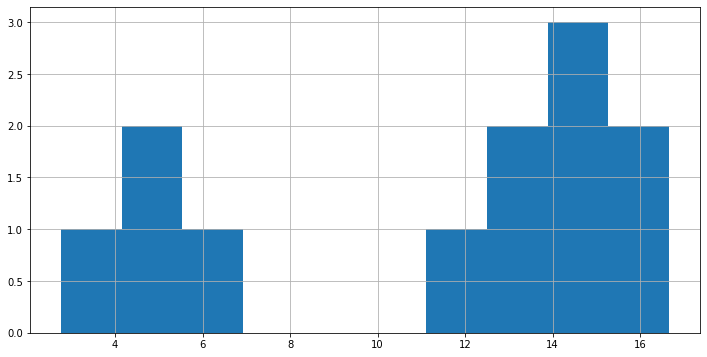

In [27]:
sums = wind.isnull().groupby([wind.index.month]).sum()
size = wind.isnull().groupby([wind.index.month]).count() / 100
(sums / size).mph.hist(bins=10, figsize=(12, 6));

Remember, though, that there are periods of extended outages. The length of these longer periods may be due to issues such as lack of parts or maintenance during certain parts of the year. It may be useful to check the distribution of the start of each NaN event.

max/min ratio: 1.95


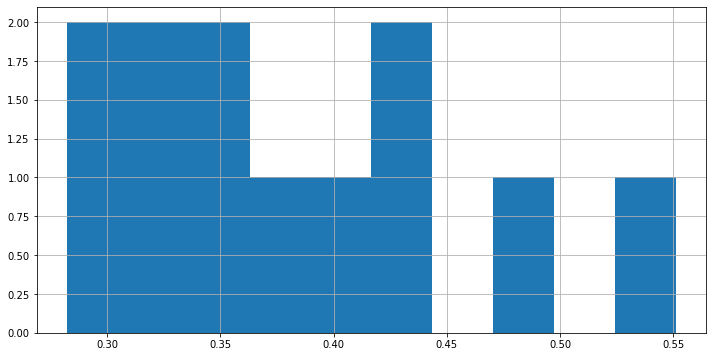

In [28]:
missing = wind.mph.isnull()
"""
    By definition, the hours before NaN events are non-null. Therefore,
    shifting the index by one, then selecting the nan events, creates
    a list with non-nan values at the start of each event. Dropping
    the nan rows selects onlythe starting hours. However, the first
    index may be NaN. It is not possible to know when the event started
    given the information provided.
"""

starting_hour_indices = wind.mph.shift(1)[missing].dropna().index

counts = wind.loc[starting_hour_indices]
counts = counts.isnull().groupby([counts.index.month]).sum()
size = wind.groupby(wind.index.month).size() / 100
quotient = counts.divide(size, axis=0)
print("max/min ratio: %.2f" % (quotient.mph.max() / quotient.mph.min()))
quotient[['mph', 'drct']].style.background_gradient(vmin=0.0, vmax=1)

counts.divide(size, axis=0).mph.hist(bins=10, figsize=(12, 6));

Although there are still peaks in Jan/Feb and Jun/Jul, the distribution is a bit more uniform. What does the time between events and length of events look like?

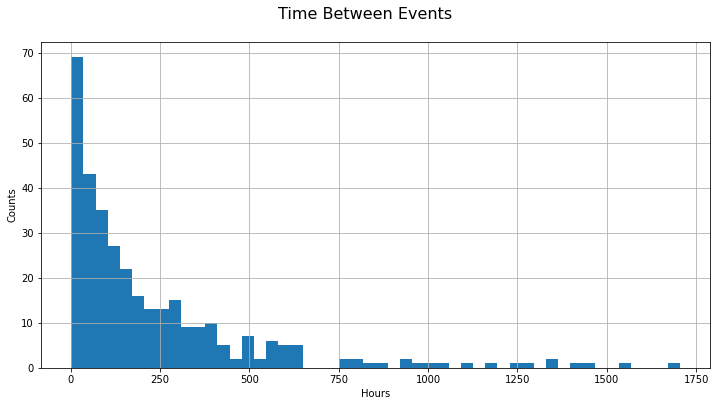

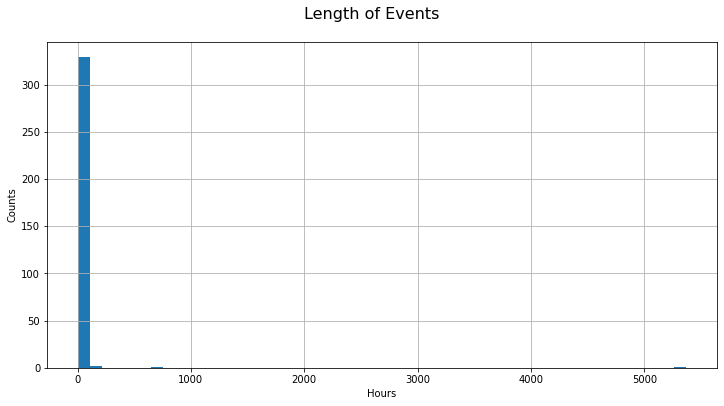

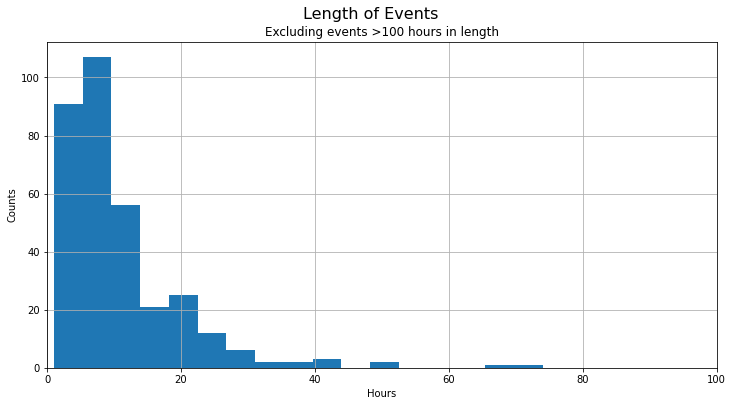

In [29]:
ending_hour_indices = wind.mph.shift(-1)[missing].dropna().index

# There is an event at the start and end of the data, therefore,
#   there is no recorded start and end respectively
length_of_events = (
    ending_hour_indices[1:] - starting_hour_indices[:-1]
).total_seconds()

# Must add one to hours to accounts for offset
# NaN at 13:00 and 14:00 is 2 hours of NaNs, not 1
length_of_events = ((length_of_events / 3600) + 1).to_series()

time_between_events = (
    starting_hour_indices - ending_hour_indices
).total_seconds()

# Opposite effect of above
time_between_events = ((time_between_events / 3600) - 1).to_series()

plot.subplots(figsize=(12, 6))
plot.suptitle('Time Between Events',fontsize=16, y=.96)
plot.xlabel('Hours')
plot.ylabel('Counts')
time_between_events.hist(bins=50)

plot.subplots(figsize=(12, 6))
plot.suptitle('Length of Events',fontsize=16, y=.96)
plot.xlabel('Hours')
plot.ylabel('Counts')
length_of_events.hist(bins=50)

plot.subplots(figsize=(12, 6))
plot.suptitle('Length of Events',fontsize=16, y=.96)
plot.title('Excluding events >100 hours in length')
plot.xlabel('Hours')
plot.ylabel('Counts')
plot.xlim(right=100)
length_of_events.hist(bins=1250);

There are several ASOS stations within 150 miles. Given the flat, open terrain, the wind nearby may be correlated with the recordings from GUY. Adding these stations may help with understanding the missing data, and it may be useful for imputation, if the data is a good candidate.

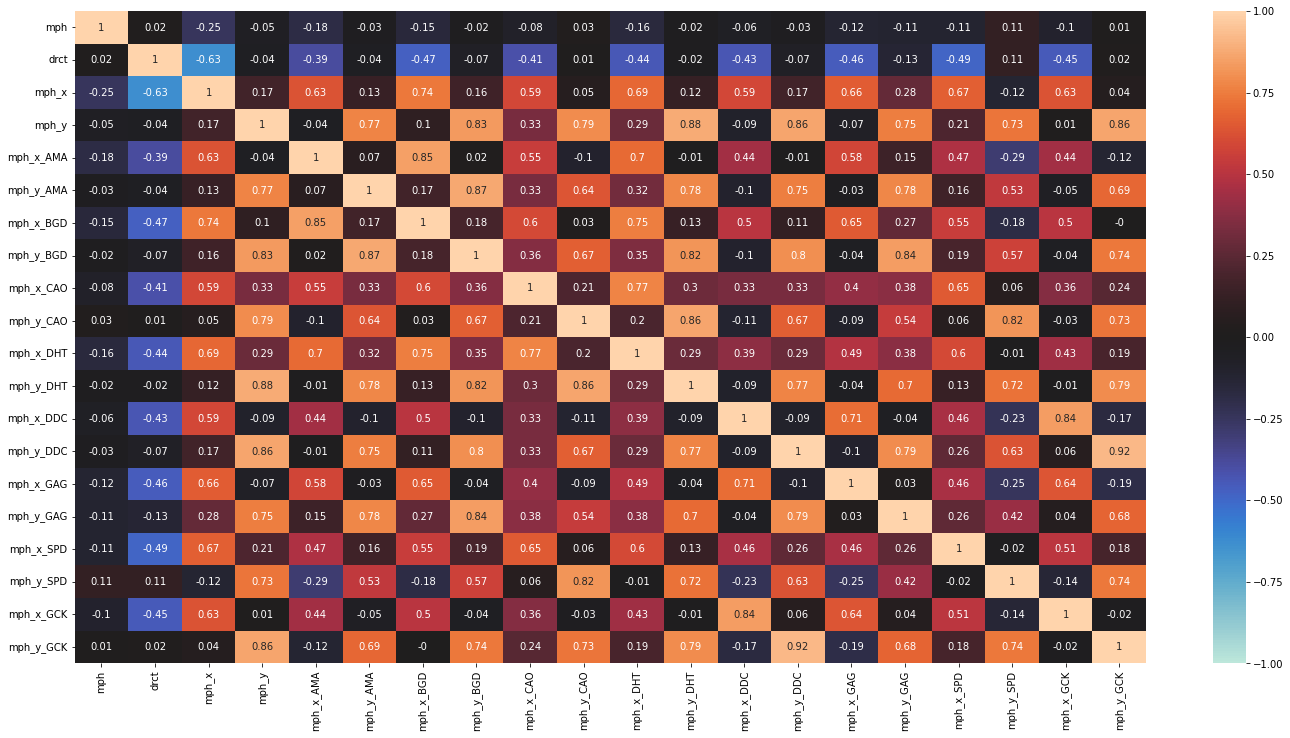

In [30]:
from seaborn import heatmap

def prep_data(station):
    station.sknt *= KNT_TO_MPH
    station = station.rename(columns={'sknt': 'mph'})
    station['mph_x'], station['mph_y'] = (
        (heading_to_vector(station.drct) 
         * np.array([station.mph])
         .T)
        .T
    )
    station = station.drop(
        columns=['station', 
                 'station_name', 
                 'lat', 
                 'lon', 
                 'mph', 
                 'drct', 
                 'Unnamed: 7'])
    station['valid(UTC)'] = pandas.to_datetime(station['valid(UTC)'], utc=True)
    station = station.set_index('valid(UTC)')
    station = station.resample('H').mean()
    station = station.reindex(index=index_dates)
    return station

def append_stations(station_list, dataframe):
    for station in station_list:
        station_data = get_data(station)
        station_data = prep_data(station_data)
        for column in station_data.columns:
            dataframe['_'.join((column, station))] = station_data[column]     
    return dataframe

wind = append_stations(['AMA', 'BGD', 'CAO', 'DHT', 'DDC', 'GAG', 'SPD', 'GCK'], wind)

fig, axs = plot.subplots(figsize=(24, 12))
heatmap(wind.corr().round(2), annot=True, vmax=1, vmin=-1, center=0);

In [31]:
def nan_coverage():
    coverage = 100 * (
         1 - (
         wind[wind.mph.isnull()].isnull().all(axis=1).sum() 
         / wind[wind.mph.isnull()].shape[0]))
    print("NaN event coverage: %.2f%%" % coverage)
    
nan_coverage()

NaN event coverage: 76.42%


There is a strong correlation with the data from surrounding stations. We can also see that there are still NaN rows, which seems unusual given the number of stations included. Could some of these events be due to ASOS/IEM network issues? Do these missing periods exist in stations in other areas? Let's add stations from Austin and Nashville.

In [32]:
wind = append_stations(['AUS', 'BNA'], wind)
nan_coverage()

NaN event coverage: 76.68%


We see nearly the same coverage. It appears that, at least for the remaining events, they are likely due to external issues. The data from the prior two stations is not needed for further analysis.

In [33]:
wind = wind.drop(columns=['mph_x_AUS', 'mph_y_AUS', 'mph_x_BNA', 'mph_y_BNA'])

Using the surrounding stations, we will try to determine if there is an unusual wind distribution surrounding the start of these events. Splitting the distributions into two groups, during and not,  could lead to a type 1 error. With the periods of extended gaps - some for weeks or months at a time - there would likely be a difference in the two distributions simply due to any differences in seasonality, even if unrelated to the missingness of the data.

With that in mind, a better option is to compare the starting hour of these events (from recordings of nearby stations), the hours immediately before and after, and the rest of the observations. Since the start of events more closely follows the distribution of recordings - and thus the seasonality - a discrepancy between these distributions may be indicative that the missingness of the measurements is related to the value of the measurements.

For this, a one way ANOVA test will be performed.

In [34]:
from scipy import stats
from datetime import timedelta

def get_indices_after(datetime_index, periods, delta):
    indices_after = []
    for index_val in datetime_index:
        for x in range(1, periods + 1):
            indices_after.append(index_val + delta)
    indices_after = (pandas
                     .DatetimeIndex(indices_after, tz=datetime_index.tz)
                     .drop_duplicates(keep='first'))
    return indices_after

hours_before_start = get_indices_after(
    starting_hour_indices, 
    3, 
    timedelta(hours=-1))

hours_after_start = get_indices_after(
    starting_hour_indices, 
    3, 
    timedelta(hours=1))

other_hours = wind[~missing 
                   & ~wind.index.isin(hours_before_start) 
                   & ~wind.index.isin(hours_after_start)
                  ].index

def sample(data):
    return data.sample(100, random_state=0).dropna().to_list()

for column in wind.columns[4:]:
    print("%s: \n%s" % 
        (column,
         stats.f_oneway(
             sample(wind.loc[hours_before_start][column]),
             sample(wind.loc[starting_hour_indices][column]),
             sample(wind.loc[hours_after_start][column]),
             sample(wind.loc[other_hours][column])
        )
       )
    )

mph_x_AMA: 
F_onewayResult(statistic=0.21224522125493345, pvalue=0.8878809282693164)
mph_y_AMA: 
F_onewayResult(statistic=0.361327920972405, pvalue=0.7809804036378932)
mph_x_BGD: 
F_onewayResult(statistic=0.22304421824951745, pvalue=0.8803482446776135)
mph_y_BGD: 
F_onewayResult(statistic=0.1277666037487972, pvalue=0.9435854296449316)
mph_x_CAO: 
F_onewayResult(statistic=0.7384505008197062, pvalue=0.5298907773334427)
mph_y_CAO: 
F_onewayResult(statistic=0.24741305228329985, pvalue=0.8631444886797258)
mph_x_DHT: 
F_onewayResult(statistic=0.3847300046060733, pvalue=0.7640901839915692)
mph_y_DHT: 
F_onewayResult(statistic=0.0018693410499064484, pvalue=0.9998881877245234)
mph_x_DDC: 
F_onewayResult(statistic=0.14473576897890394, pvalue=0.9330010229885055)
mph_y_DDC: 
F_onewayResult(statistic=0.0659585654593665, pvalue=0.9778883395044179)
mph_x_GAG: 
F_onewayResult(statistic=0.37221279570203303, pvalue=0.773120226626923)
mph_y_GAG: 
F_onewayResult(statistic=0.19668841719194674, pvalue=0.898

As you can see from the corresponding p-values, we have failed to reject the null hypothesis. Therefore, winds at surrounding stations during the start of events are not statistically different from the periods without events. Given the evidence at hand, it seems probable that the missing observations from the Guymon station are not MNAR. This indicates that imputation should lead to reliable results.

For imputation, we will be using the IterativeImputer from sklearn with the default Bayesian Ridge estimator. We will impute the wind vectors, not speed and direction.

In [35]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(random_state=0, sample_posterior=True)

wind = wind.drop(columns=['mph', 'drct'])

wind = (
    pandas
    .DataFrame(
        imputer.fit_transform(wind.copy()), 
        columns=wind.columns, 
        index=wind.index)
    [['mph_x', 'mph_y']]
)

Now we can calculate speed and direction from the imputed vectors.

In [36]:
wind['mph'] = np.sqrt(wind.mph_x**2 + wind.mph_y**2)
wind['drct'] = vector_to_heading(wind.mph_x, wind.mph_y)

It would be handy to have a column denoting whether each measurement was taken during the day or night. To accomplish this, we will use the astral library to fetch the sunrise and sunset times at the ASOS station's location during the timeframe of the reported data.

In [37]:
from astral import LocationInfo
import datetime
from astral.sun import sun


def get_daylight_hours(date, city):
    s = sun(city.observer, date=date)
    return s['sunrise'], s['sunset']

city = LocationInfo(latitude=LAT, longitude=LON)

dates = (pandas.date_range(
            start=wind.index.date.min(),
            end=wind.index.date.max())
         .to_series())

daylight_intervals = (pandas.IntervalIndex.from_tuples(
        dates.apply(lambda date: get_daylight_hours(date, city)),
        closed='both'))

Now that we have the times for sunrise and sunset, we will create a boolean column for daylight status by re-indexing our *daylight_intervals* against the *wind* index. Next, the index location array will be used *wind* to determine if each sample fell within a daylight interval.

In [38]:
# Reindex includes an array containing the index value of 
#   the row within the original index (daylight hours intervals).
# Therefore, < 0 indicates that the datetime was not in original index (not 
#   in daylight hours), and thus it is night.
wind['day'] = daylight_intervals.reindex(wind.index)[-1] >= 0

## Local Wind Patterns

Now we can take a look at the wind patterns in Guymon Oklahoma. We will start by plotting the average wind speeds over the course of a year.

In [39]:
from matplotlib import dates

def fill_percentiles(data, x_axis, ax, rolling_period=0):
    for lower, upper in zip([.1, .25], [.9, .75]):
        if rolling_period > 0:
            low = data.quantile(lower).rolling(rolling_period).mean()
            high = data.quantile(upper).rolling(rolling_period).mean()
        else:
            low = data.quantile(lower)
            high = data.quantile(upper)
        ax.fill_between(
            x_axis,
            low,
            high,
            alpha=0.25
        )

def plot_rolling_windspeeds(data, column, ax, period=7, plot_bands=False):   
    grouped = data.groupby([data.index.month, data.index.day])[column]
    
    x = pandas.date_range(start='1/1/2000', periods=len(grouped), freq='D')    
    y = grouped.mean().rolling(period).mean()
    
    if plot_bands:
        fill_percentiles(grouped, x, ax, rolling_period=7)
    
    ax.plot(x, y)         
    ax.set_xlabel('Months')
    ax.set_ylabel('Speed (MPH)')
    ax.xaxis.set_major_formatter(dates.DateFormatter("%b"))
    ax.xaxis.set_major_locator(dates.MonthLocator())
    ax.set_ylim(bottom=0)

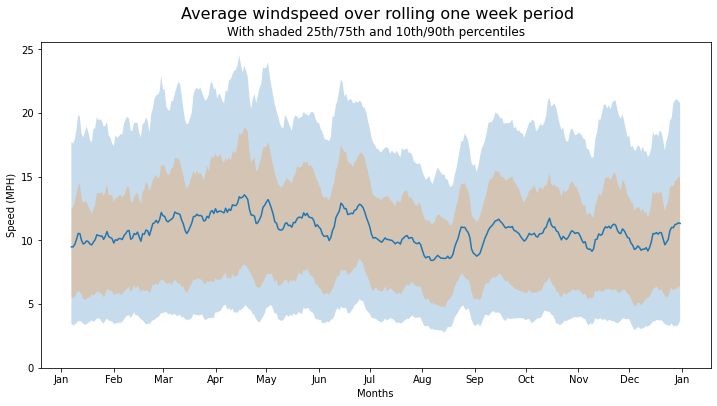

In [40]:
figure, axes = plot.subplots(figsize=(12, 6))
figure.suptitle(
    'Average windspeed over rolling one week period', 
    fontsize=16, 
    x=.515,
    y=.96)
axes.set_title('With shaded 25th/75th and 10th/90th percentiles')

plot_rolling_windspeeds(wind, 'mph', axes, plot_bands=True)

It's fairly windy on the high plains. What about day vs night averages?

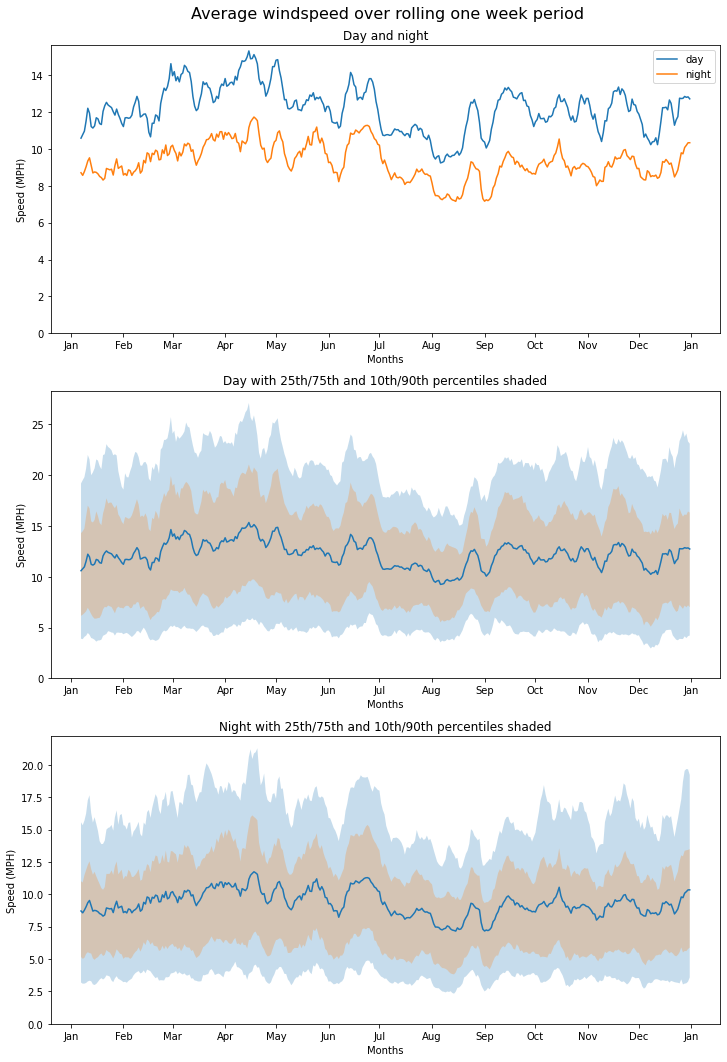

In [41]:
figure, axes = plot.subplots(3, 1, figsize=(12, 18))
figure.suptitle(
    'Average windspeed over rolling one week period', 
    fontsize=16, 
    x=.515,
    y=.91)

axes[0].set_title('Day and night')
plot_rolling_windspeeds(wind[wind.day], 'mph', axes[0])
plot_rolling_windspeeds(wind[~wind.day], 'mph', axes[0])

axes[0].legend(labels=['day', 'night']);

axes[1].set_title('Day with 25th/75th and 10th/90th percentiles shaded')
plot_rolling_windspeeds(wind[wind.day], 'mph', axes[1], plot_bands=True)

axes[2].set_title('Night with 25th/75th and 10th/90th percentiles shaded')
plot_rolling_windspeeds(wind[~wind.day], 'mph', axes[2], plot_bands=True)

The wind speeds at night do slow down a bit. Let's plot the hourly averages.

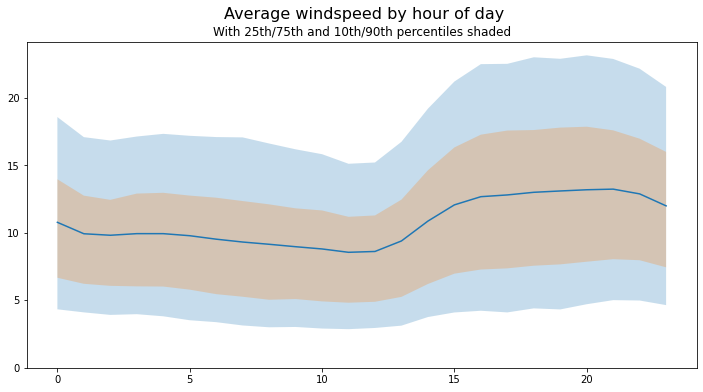

In [42]:
figure, axes = plot.subplots(figsize=(12, 6))
figure.suptitle(
    'Average windspeed by hour of day', 
    fontsize=16, 
    x=.515,
    y=.96)

axes.set_title('With 25th/75th and 10th/90th percentiles shaded')
wind.groupby([wind.index.hour]).mean().mph.plot(ax=axes)
fill_percentiles(wind.groupby([wind.index.hour]).mph, range(0, 24), axes)
axes.set_ylim(bottom=0);

We can see a large bump in the afternoon winds, which mellow into the night. Since the station is located in Central Time (-5 to -6), this places the peak around 4pm to 5pm.

Now it is time to look at distributions, starting with scatter plots.

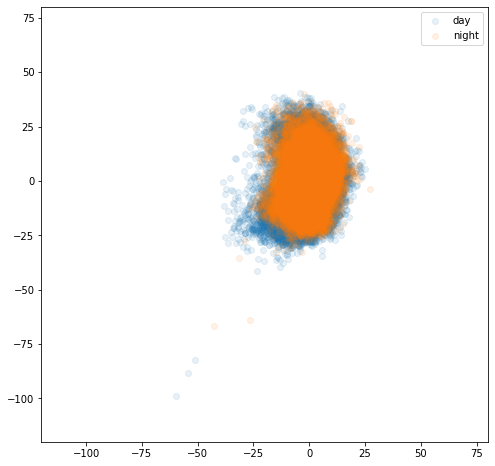

In [43]:
figure, axes = plot.subplots(figsize=(8, 8))
plot.scatter(x=wind[wind.day].mph_x, y=wind[wind.day].mph_y, alpha=0.1, label='day')
plot.scatter(x=wind[~wind.day].mph_x, y=wind[~wind.day].mph_y, alpha=0.1, label='night')
axes.set_ylim(bottom=-120, top=80)
axes.set_xlim(left=-120, right=80)
axes.legend();

We again see night winds slower than the day winds, as indicated by the night points staying within the bounds of the plotted day points. There appears to be a very prominent North and South trend, skewed slightly towards N/NE and S/SW for the day winds. We can also see a shifting of the winds slightly to the west during the night.

A few points of note are in the lower left, with winds reaching incredible speeds of ~60mph W and 100mph S! In the author's personal experience, those are not unbelievable speeds. However, since the data is imputed, we cannot rely on any single point. The distribution, on the whole, though, should be accurate. 

Plotting in a wind rose will give us a better indication of the speed and direction distributions. Once again, we will split the plots into day and night winds. It is common practice with wind rose charts to discard the low wind speeds. For ASOS stations, low speeds may not have accurate direction readings. We will be discarding all winds below three miles per hour.

Day calm: 1.96%
Night calm: 2.04%


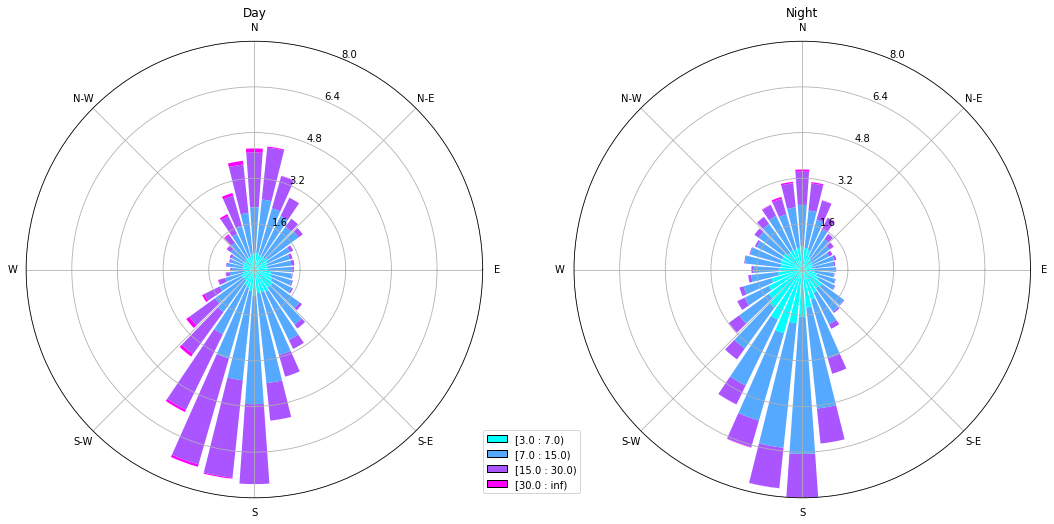

In [44]:
from windrose import WindroseAxes
from matplotlib import cm

bins = [3, 7, 15, 30]
rmax = 8
nsector = 36
cmap=cm.cool

print('Day calm: %.2f%%' % (
    wind[wind.day & wind.mph < 3].mph.count()
    / wind[wind.day].mph.count()
))

print('Night calm: %.2f%%' % (
    wind[~wind.day & wind.mph < 3].mph.count()
    / wind[~wind.day].mph.count()
))

figure = plot.figure(figsize=(18, 18))

axes = figure.add_subplot(1, 2, 1, projection="windrose", rmax=rmax)
axes.bar(
    wind[wind.day].drct, 
    wind[wind.day].mph, 
    bins=bins, 
    nsector=nsector, 
    cmap=cmap, 
    normed=True)
axes.set_title('Day')

axes.legend(loc='lower right', bbox_to_anchor=(1.225, 0))

axes = figure.add_subplot(1, 2, 2, projection="windrose", rmax=rmax)
axes.bar(
    wind[~wind.day].drct, 
    wind[~wind.day].mph, 
    bins=bins, 
    nsector=nsector, 
    cmap=cmap, 
    normed=True)

axes.set_title('Night');

Here the North/South trend is especially visible. It appears to become more prominent as the wind speeds increase.

## Runway Optimization

### Preparation
The goal is to determine optimal runway configurations according to determined criteria. As previously stated, crosswinds are the wind components perpendicular to the runway. Therefore, we will need to compute the vector rejection (perpendicular component) of the wind from the runway.

To accomplish this, we can utilize the following vector relationships.

In [45]:
%load_ext tikzmagic

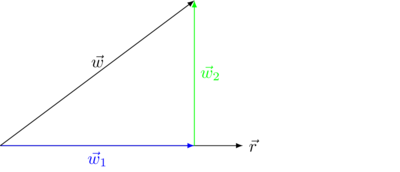

In [46]:
%%tikz
\draw [-latex](0,0) -- (5,0) node [right,text width=3cm]{$\vec{r}$};
\draw [blue, -latex](0,0) -- (4,0) node [below,text width=3cm, text centered, midway]{$\vec{w}_{1}$};
\draw [-latex](0,0) -- (4,3) node [above,text width=3cm,text centered,midway]{$\vec{w}$};
\draw [green, -latex](4,0) -- (4,3) node [right,text width=3cm, midway]{$\vec{w}_{2}$};

$
\begin{align}
reject_{\vec{r}}\vec{w} &= \vec{w}_{2} \\
            &= \vec{w} - \vec{w}_{1} \\
            &= \vec{w} - proj_{\vec{r}}\vec{w}\\
            &= \vec{w} - {w \cdot r \over \lVert \vec{r}\rVert^2} \vec{r}
\end{align}
$

Now we can implement *vector_projection* and *vector_rejection* functions. We should vectorize the functions for speed.

In [47]:
"""
a and b are arrays of vectors in the form:
 [[x1, y1],
  [x2, y2],
  ...
  [xn, yn]]
"""

def vector_projection(a, b):
    # Must reshape resultant 2D to a 3D array for further processing
    dot_prod = a.dot(b.T).reshape(len(a), len(b), 1)
    mag = np.linalg.norm(b, axis=1).reshape(1, len(b), 1)
    
    # a.b * b / ||b||^2
    return dot_prod * b / mag**2

""" 
Resulting array:
 [
  [[x, y], <- resulting vector rejection for runway 1, wind vector 1
   [x, y], <- runway 2, wind 1
   [x, y]],<- runway 3, wind 1

  [[x, y], <- runway 1, wind 2
   [x, y], <- runway 2, wind 2
   [x, y]],<- runway 3, wind 2
   ...
 ] 
"""
def vector_rejection(a, b):
    return a.reshape(len(a), 1, 2) - vector_projection(a, b)

Now we must consider the optimization function. A basic approach could be to reduce the crosswind error. That is, the square of the magnitude of the resulting crosswinds for any given runway configuration.

In [48]:
# fixed_runways array variable for pre-defined runways
def crosswind_error(runways, wind_vecs, fixed_runways):
    # All of the runway headings must be converted to vectors
    runway_vecs = heading_to_vector(np.append(runways, fixed_runways))
    
    # Compute the magnitude for all resulting vector rejections
    crosswinds = (np.linalg.norm(
                    vector_rejection(wind_vecs, runway_vecs),
                    axis=2)
                  .T)
    
    # Each wind vector will have a rejection for each runway. Since pilots
    # can choose the most favorable runway, we will choose the lowest resulting
    # crosswind magnitude for every wind vector. Square results and return sum.
    return np.nansum(np.nanmin(np.array(crosswinds), axis=0)**2)

An alternative approach is to minimize the number of hours of crosswind above a specific threshold. This is how full scale runways are configured. A crosswind component threshold is typically specified based on the type of aircraft that will be typical for that site.

In [49]:
def hours_of_heavy_crosswind(runways, wind_vecs, max_crosswind, fixed_runways):
    # Same as crosswind_error
    runway_vecs = heading_to_vector(np.append(runways, fixed_runways))
    crosswinds = (np.linalg.norm(
                    vector_rejection(wind_vecs, runway_vecs),
                    axis=2)
                  .T)
    
    # Here we will once again select the lowest crosswind value, but we
    # then compare the results to the max_crosswind and count the number
    # of True results
    return np.count_nonzero(np.nanmin(np.array(crosswinds), axis=0) > max_crosswind)

For the optimization algorithm, we will be using differential evolution from SciPy, although a simpler algorithm would also suffice.

Before we optimize, we need to determine what we are optimizing for. Since most, if not all, all flying at this field occurs during the day, we will limit the data to daytime winds. Additionally, wind speeds above 15 mph will see most flyers staying home, regardless of crosswind conditions. Therefore, we will only include winds of less than 15 mph. We will also use the hour scoring function with a crosswind threshold of 5 mph. 

Lear Field currently sports a Geotextile runway on top of Caliche dirt work. The single runway is aligned at roughly 2 degrees east of north. The club has been preparing to add additional runways at 45 and 135 degrees, with dirt work completed for both. Let's see how close this configuration is to optimum.

In [50]:
max_wind = 15
max_crosswind = 5

wind = wind[wind.day & (wind.mph < max_wind) & (wind.mph >= max_crosswind)]
wind_vecs = np.array([wind.mph_x, wind.mph_y]).T

# Since runways are bi-directional, their placement can be bounded to 0-180
bounds = [(0, 180), (0, 180)]
fixed_runways = [2]

### Results

In [51]:
from scipy.optimize import differential_evolution

degree_symbol = chr(176)
kwargs = {
    'seed': 0,
    'maxiter': 5000,
    'init': 'sobol'
}

res_hours = differential_evolution(
    hours_of_heavy_crosswind, 
    bounds, 
    args=(wind_vecs, max_crosswind, fixed_runways),
    **kwargs
)

single_runway_hours = hours_of_heavy_crosswind(
    [], 
    wind_vecs, 
    max_crosswind, 
    fixed_runways
)
proposed_runway_hours = (
    hours_of_heavy_crosswind(
        [45, 135], 
        wind_vecs, 
        max_crosswind, 
        fixed_runways
    )
)

def percent_reduction(new, base):
    return 100 * (1 - new / base)

def print_runways(runways):
    runway_str = ''
    for runway in runways:
        runway_str += " %.2f" % runway + degree_symbol
    print(
        "Runway configuration for minimizing hours of heavy crosswind:" 
        + runway_str
    )
    
        
print_runways(res_hours['x'])
print(
    "Percent reduction over current: %.2f%%" 
    % percent_reduction(res_hours['fun'], single_runway_hours)
)
print(
    "Percent improvement from proposed: %.2f%%" 
    % percent_reduction(res_hours['fun'], proposed_runway_hours)
)

Runway configuration for minimizing hours of heavy crosswind: 49.05° 135.22°
Percent reduction over current: 85.05%
Percent improvement from proposed: 4.51%


As you can see, there is a slight improvement over the proposed runways, and a significant improvement from the single runway.

What if only one runway was added?

In [52]:
single_additional_runway = differential_evolution(
    hours_of_heavy_crosswind, 
    [(0, 180)], 
    args=(wind_vecs, max_crosswind, fixed_runways),
    **kwargs
)

print_runways(single_additional_runway['x'])
print(
    "Percent reduction over current: %.2f%%" 
    % percent_reduction(single_additional_runway['fun'], single_runway_hours)
)

Runway configuration for minimizing hours of heavy crosswind: 56.00°
Percent reduction over current: 49.18%


A single additional runway claims a majority of the decrease in crosswind hours.

For fun, let's assume we are starting from scratch and have no preexisting runway. What would the optimum orientations be for 1, 2, and 3 runway layouts?

In [53]:
res_single = differential_evolution(
    hours_of_heavy_crosswind, 
    [(0, 180)], 
    args=(wind_vecs, max_crosswind, []),
    **kwargs
)
res_double = differential_evolution(
    hours_of_heavy_crosswind,  
    [(0, 180), (0, 180)], 
    args=(wind_vecs, max_crosswind, []),
    **kwargs
)
res_triple = differential_evolution(
    hours_of_heavy_crosswind,  
    [(0, 180), (0, 180), (0, 180)], 
    args=(wind_vecs, max_crosswind, []),
    **kwargs
)

print_runways(res_single['x'])
print(
    "Percent reduction over current: %.2f%%"
    % percent_reduction(res_single['fun'], single_runway_hours)
)

print_runways(res_double['x'])
print(
    "Percent reduction over current: %.2f%%"
    % percent_reduction(res_double['fun'], single_runway_hours)
)

print_runways(res_triple['x'])
print(
    "Percent reduction over current: %.2f%%"
    % percent_reduction(res_triple['fun'], single_runway_hours)
)

Runway configuration for minimizing hours of heavy crosswind: 4.16°
Percent reduction over current: 0.46%
Runway configuration for minimizing hours of heavy crosswind: 29.52° 159.71°
Percent reduction over current: 55.67%
Runway configuration for minimizing hours of heavy crosswind: 159.31° 85.71° 25.41°
Percent reduction over current: 86.33%


Let's chart the resulting crosswinds for a few of the configurations.

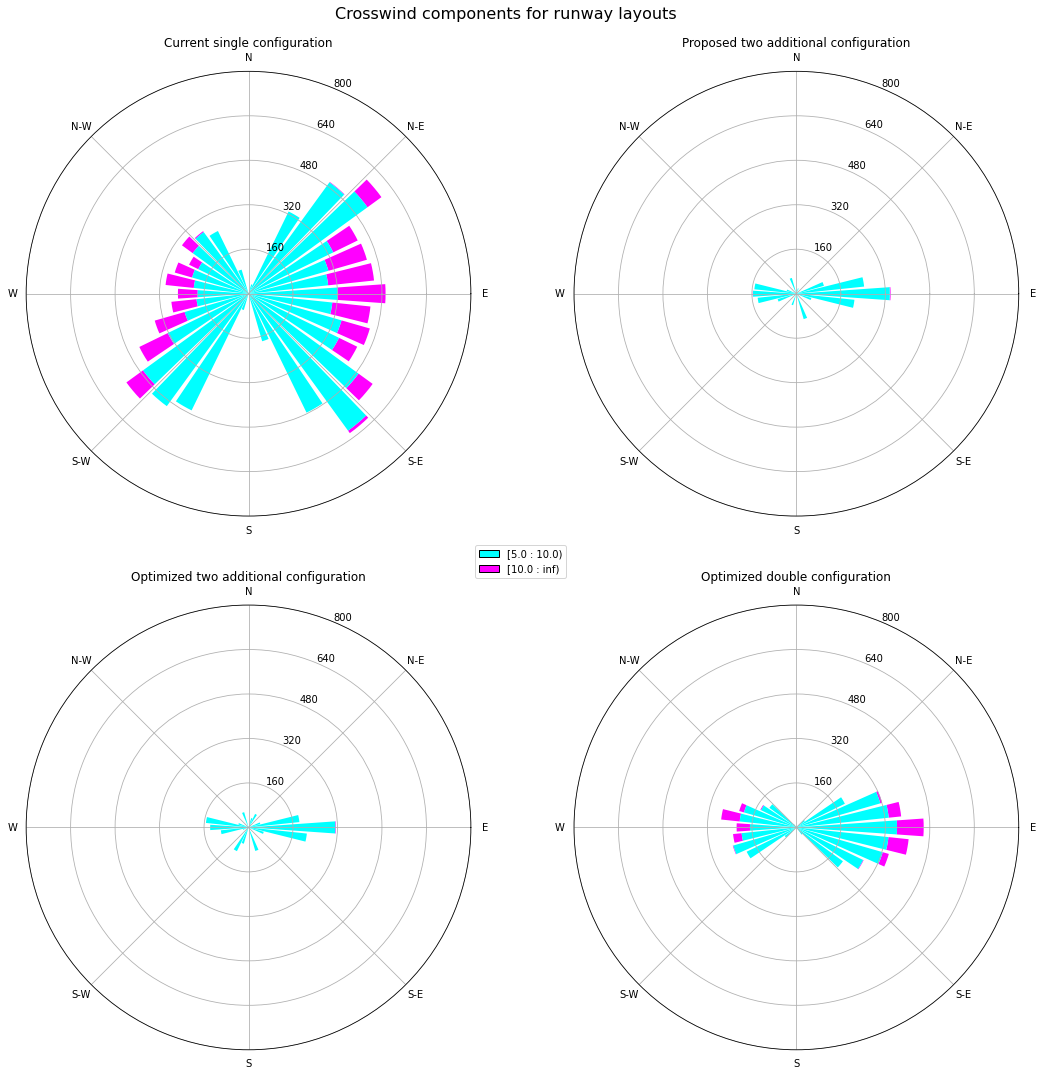

In [54]:
# Finds the lowest crosswind component for the provided runways
def compute_min_crosswind(wind_vecs, runways):
    crosswinds = vector_rejection(wind_vecs, runways)
    return np.min(np.linalg.norm(crosswinds, axis=2), axis=1)


wind['current_crosswind'] = compute_min_crosswind(
    np.array([wind['mph_x'], wind['mph_y']]).T,
    heading_to_vector(np.array(fixed_runways))
)

wind['proposed_crosswind'] = compute_min_crosswind(
    np.array([wind['mph_x'], wind['mph_y']]).T,
    heading_to_vector(np.append(fixed_runways, [45, 135]))
)

wind['two_additional_crosswind'] = compute_min_crosswind(
    np.array([wind['mph_x'], wind['mph_y']]).T,
    heading_to_vector(
        np.append(fixed_runways, res_hours['x'])
    )
)

wind['optimized_double'] = compute_min_crosswind(
    np.array([wind['mph_x'], wind['mph_y']]).T,
    heading_to_vector(np.append(fixed_runways, res_double['x']))
)

rmax=800
bins = [max_crosswind, 10]

figure = plot.figure(figsize=(18, 18))
figure.suptitle(
    'Crosswind components for runway layouts', 
    fontsize=16, 
    y=.93
)

axes = figure.add_subplot(2, 2, 1, projection="windrose", rmax=rmax)
axes.bar(
    wind.drct, 
    wind.current_crosswind, 
    bins=bins, 
    nsector=nsector, 
    cmap=cmap, 
    #normed=True
)
axes.set_title('Current single configuration')

axes.legend(loc='lower right', bbox_to_anchor=(1.225, -.15))

axes = figure.add_subplot(2, 2, 2, projection="windrose", rmax=rmax)
axes.bar(
    wind.drct, 
    wind.proposed_crosswind, 
    bins=bins, 
    nsector=nsector, 
    cmap=cmap, 
    #normed=True
)
axes.set_title('Proposed two additional configuration')

axes = figure.add_subplot(2, 2, 3, projection="windrose", rmax=rmax)
axes.bar(
    wind.drct, 
    wind.two_additional_crosswind, 
    bins=bins, 
    nsector=nsector, 
    cmap=cmap, 
    #normed=True
)
axes.set_title('Optimized two additional configuration')

axes = figure.add_subplot(2, 2, 4, projection="windrose", rmax=rmax)
axes.bar(
    wind.drct, 
    wind.optimized_double, 
    bins=bins, 
    nsector=nsector, 
    cmap=cmap, 
    #normed=True
)
axes.set_title('Optimized double configuration');

## Recommendation

The optimized configuration requires only slight modification to one of the proposed runways. If airfield members are open to minor alteration of the dirt work, there is little reason not to. Otherwise, the proposed configuration is close to optimum.

If the current runway was being replaced, and dirt work had not already been completed, the dual runway setup would be a very attractive option. It covers the majority of crosswind components of the triple runway setup with one less runway. The cost of Geotextile runways, while cheaper than alternatives for non-grass airfields, is considerable. Furthermore, the optimized dual runway setup places the two runways at shallower angles (closer to N/S), which is beneficial from a safety standpoint. 

Lear Field has a pit area perpendicular to the runway at 100' back, spectators at parking at 125', and a North/South road at 250'. With the shallow runway angles, it allows for a central placement close to the pits (in an X configuration), while still allowing for a margin of safety from the pits and spectator area.